# An introduction in processing and visualization of IoT data

## 1. Getting the data via HTTP GET request

### 1.1 Definition of keys and API access point

cenote Documentation:

http://assist.ee.auth.gr/docs/

In [1]:
PROJECT   = 'pide23f7ea9d71'
READ_KEY  = 'c55787bd-f262-413a-abb5-dfd07896ef75'
WRITE_KEY = 'bdaf39d4-6f58-4f40-a953-5c285c26ea94'

PROJECT   = 'pidc06ebaeb8e6'
READ_KEY  = 'd5c81802-a1f6-46a2-ad31-8be10d7172f4'
WRITE_KEY = 'cc5d8392-1226-42c6-a1e2-2d4555a67682'

URL = "https://cenote.sidero.services/api/projects/" + PROJECT

### 1.2 Define and test the functions

We begin by defining an abstract function that performs a GET request.

To account for the different type of queries, this function is query type agnostic.
It thus passes the type of query and the query arguments to the GET request.
Should the query by unsuccessful, a RuntimeError is raised.

In [2]:
import requests

def cenote_get(event_name, query_type, query_dict={}):
    get_url = "{0}/queries/{1}".format(URL, query_type)
    query_dict["readKey"] = READ_KEY
    query_dict["event_collection"] = event_name
    r = requests.get(get_url, query_dict)
    r = dict(r.json())
    if r["ok"]:
        return r["results"]
    else:
        raise RuntimeError("Query unsuccessful due to {0}. Message is: {1}".format(
            r["results"], r["message"]))

We test the efficacy of the function on known data and known unknowns (:

In [11]:
cenote_get("measurements", "extraction", {"latest": 1})

[{'filename': 'ADU-700HP_V2_200702211530.TXT',
  'f': '31.2.1',
  'pn': '+306948701112',
  'uid': '00000001',
  'un': 'ADU-700HP_V2',
  'dt': '02/07/2020 15:20:24',
  'ch': '18',
  'gps': '0',
  'epoch': 1593693624000,
  'solar': '821',
  'precipitation': '0.000',
  'windspeed': '2.65',
  'winddirection': '145.1',
  'temperature': '33.9',
  'humidity': '0.444',
  'cntv2': '0',
  'vwc1': '6.05',
  'temp1': '35.9',
  'ec1': '54',
  'vwc2': '4.48',
  'temp2': '33.6',
  'ec2': '15',
  'analogv1': None,
  'cntv1': None,
  'analogv3': None,
  'cntv3': '100.0',
  'cntvm': None,
  'uuid': 'd571869f-7e95-4b35-aaf2-1aa2cd8a00b1',
  'cenote$created_at': 1602142459710,
  'cenote$timestamp': 1602142459710,
  'cenote$id': '84a6e6f9-017d-4d7d-8882-6cb2e01201a6',
  'ai21temp': None,
  'ai22rh': None,
  'ai23cnt1': None,
  'ai31level': None,
  'ai32cnt1': None,
  'unknown16': '0'}]

In [8]:
cenote_get("NOT_EXISTING", "extraction", {"latest": 2})

RuntimeError: Query unsuccessful due to BadQueryError. Message is: relation "pide23f7ea9d71_not_existing" does not exist

**Cenote also supports some higher level quering ...**

In [48]:
cenote_get("measurements", "minimum", {"target_property": "temperature"})

[{'min': '-0.1'}]

### 1.3 Get and store the data in a dataframe

pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.

It provides:

* a fast and efficient **DataFrame** object for data manipulation with integrated indexing;
* tools for reading and writing data between in-memory data structures and different formats: CSV and text files, Microsoft Excel, SQL databases, and the fast HDF5 format;
* flexible reshaping and pivoting of data sets;
* intelligent label-based slicing, fancy indexing, and subsetting of large data sets


A quick [guide may be found here](https://pandas.pydata.org/docs/user_guide/index.html#user-guide), with the complete [API reference being provided here](https://pandas.pydata.org/docs/reference/index.html)

In [3]:
import pandas

# Custom filter on extraction to get data from a given sensor only
cus_filter = '[{"property_name":"un","operator":"eq","property_value":"ADU-700HP_V2"}]'
res = cenote_get("measurements", "extraction", {"filters": cus_filter, "latest": 50000})

# Transform query result to a pandas DataFrame
df = pandas.DataFrame(res)
df = df.sort_values(by="epoch").drop_duplicates(subset="epoch").reset_index(drop=True)
df

,filename,f,pn,uid,un,dt,ch,gps,epoch,solar,...,uuid,cenote$created_at,cenote$timestamp,cenote$id,ai21temp,ai22rh,ai23cnt1,ai31level,ai32cnt1,unknown16
0,ADU-700HP_V2_191207152030.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,07/12/2019 09:25:24,18,0,1575711924000,73,...,dffc1989-7ea1-4c45-b190-70d579a45bfe,1575721425134,1575721425134,9116b3b9-3ed0-4375-bdfa-abb5c651ed2f,None,None,None,None,None,None
1,ADU-700HP_V2_191207152030.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,07/12/2019 09:25:24,18,0,1575712224000,59,...,51e567ca-d71b-46ec-bcc6-c5caecb7c079,1575721425236,1575721425236,5f08d3b3-9c63-4e62-a6da-be432b07df2c,None,None,None,None,None,None
2,ADU-700HP_V2_191207152030.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,07/12/2019 09:25:24,18,0,1575712524000,61,...,5e731356-3ed2-4ba7-b3bb-a433fcbb1919,1575721425354,1575721425354,f18dafad-4eea-4127-a71d-575bc40103c0,None,None,None,None,None,None
3,ADU-700HP_V2_191207152030.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,07/12/2019 09:25:24,18,0,1575712824000,73,...,86be0509-6962-4981-a4cd-5cf1fb94b2db,1575721425454,1575721425454,d626b9b1-c9ff-4246-b285-a2c7c1640a8a,None,None,None,None,None,None
4,ADU-700HP_V2_191207152030.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,07/12/2019 09:25:24,18,0,1575713124000,86,...,b8f4dc46-f980-49bf-b4ac-965e9ad25c98,1575721425572,1575721425572,7f052486-a552-4d59-844e-a980697666d6,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46159,ADU-700HP_V2_200702151552.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,02/07/2020 09:20:24,18,0,1593677724000,673,...,9d8e03f3-1d24-4755-9568-739e55befef8,1602142426834,1602142426834,f94b7bc2-9a03-4bf8-bb86-7d0c6f407f79,None,None,None,None,None,0
46160,ADU-700HP_V2_200702211530.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,02/07/2020 15:20:24,18,0,1593692724000,842,...,931cc5d3-7d5e-4931-8c87-394fdf6988f8,1602142459121,1602142459121,855dcd18-8072-4bbd-93a6-4dedbc349891,None,None,None,None,None,0
46161,ADU-700HP_V2_200702211530.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,02/07/2020 15:20:24,18,0,1593693024000,838,...,3ed8d3d2-4c42-475c-afcf-ca66e1a471be,1602142459301,1602142459301,0b112eaf-3d92-41ae-b494-3318ed70475f,None,None,None,None,None,0
46162,ADU-700HP_V2_200702211530.TXT,31.2.1,+306948701112,00000001,ADU-700HP_V2,02/07/2020 15:20:24,18,0,1593693324000,832,...,4bc4a764-fdcd-4d1e-9fb2-8962d0da2720,1602142459524,1602142459524,14ba4a95-50e3-49bc-9e37-2755a15a736a,None,None,None,None,None,0


## 2. Initial data exploration

Now is a good idea to gauge what kind of data are stored in the DataFrame.

To this end, we explore the columns and the types of data stored.

In [4]:
df.columns

Index(['filename', 'f', 'pn', 'uid', 'un', 'dt', 'ch', 'gps', 'epoch', 'solar',
       'precipitation', 'windspeed', 'winddirection', 'temperature',
       'humidity', 'cntv2', 'vwc1', 'temp1', 'ec1', 'vwc2', 'temp2', 'ec2',
       'analogv1', 'cntv1', 'analogv3', 'cntv3', 'cntvm', 'uuid',
       'cenote$created_at', 'cenote$timestamp', 'cenote$id', 'ai21temp',
       'ai22rh', 'ai23cnt1', 'ai31level', 'ai32cnt1', 'unknown16'],
      dtype='object')

In [5]:
df.dtypes

filename             object
f                    object
pn                   object
uid                  object
un                   object
dt                   object
ch                   object
gps                  object
epoch                 int64
solar                object
precipitation        object
windspeed            object
winddirection        object
temperature          object
humidity             object
cntv2                object
vwc1                 object
temp1                object
ec1                  object
vwc2                 object
temp2                object
ec2                  object
analogv1             object
cntv1                object
analogv3             object
cntv3                object
cntvm                object
uuid                 object
cenote$created_at     int64
cenote$timestamp      int64
cenote$id            object
ai21temp             object
ai22rh               object
ai23cnt1             object
ai31level            object
ai32cnt1            

**Some of these data types may be auto-magically corrected ...**

In [6]:
df = df.convert_dtypes()
df.dtypes

filename             string
f                    string
pn                   string
uid                  string
un                   string
dt                   string
ch                   string
gps                  string
epoch                 Int64
solar                string
precipitation        string
windspeed            string
winddirection        string
temperature          string
humidity             string
cntv2                string
vwc1                 string
temp1                string
ec1                  string
vwc2                 string
temp2                string
ec2                  string
analogv1             string
cntv1                string
analogv3             string
cntv3                string
cntvm                string
uuid                 string
cenote$created_at     Int64
cenote$timestamp      Int64
cenote$id            string
ai21temp             object
ai22rh               object
ai23cnt1             object
ai31level            object
ai32cnt1            

**While for others, we need to manually fix them ...**

In [7]:
keys = ['solar', 'precipitation', 'windspeed', 'winddirection', 'temperature', 'humidity', 
        'cntv2', 'vwc1', 'temp1', 'ec1', 'vwc2', 'temp2', 'ec2', 'analogv1', 'cntv1',
        'analogv3', 'cntv3', 'cntvm']

for key in keys:
    df[key] = pandas.to_numeric(df[key], errors="coerce")

df.epoch = pandas.to_datetime(df.epoch, unit='ms')

df.dtypes

filename                     string
f                            string
pn                           string
uid                          string
un                           string
dt                           string
ch                           string
gps                          string
epoch                datetime64[ns]
solar                       float64
precipitation               float64
windspeed                   float64
winddirection               float64
temperature                 float64
humidity                    float64
cntv2                       float64
vwc1                        float64
temp1                       float64
ec1                         float64
vwc2                        float64
temp2                       float64
ec2                         float64
analogv1                    float64
cntv1                       float64
analogv3                    float64
cntv3                       float64
cntvm                       float64
uuid                        

**We can also very easily see some statistical moments that describe our data**

In [8]:
df.describe()

,solar,precipitation,windspeed,winddirection,temperature,humidity,cntv2,vwc1,temp1,ec1,vwc2,temp2,ec2,analogv1,cntv1,analogv3,cntv3,cntvm,cenote$created_at,cenote$timestamp
count,45786.000000,45786.000000,45786.000000,45786.000000,45786.000000,45786.000000,45475.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,45736.000000,41884.000000,41884.000000,46024.0,46051.000000,7578.000000,4.616400e+04,4.616400e+04
mean,10.293037,0.001789,1.550084,184.602018,12.486179,0.375096,0.044860,9.476752,16.075984,107.658278,7.611044,15.796464,52.351998,23.774045,1.706117,100.0,2.815835,6.834257,1.586550e+12,1.586550e+12
std,52.066054,0.079884,1.251834,95.435863,132.556053,26.434701,0.296083,2.521698,7.364909,35.000406,2.262546,6.687088,28.620167,5.215498,4.086089,0.0,4.908060,13.479491,5.450966e+09,5.450966e+09
min,0.000000,0.000000,0.030000,0.100000,-9999.000000,-1999.432000,0.000000,5.720000,3.000000,50.000000,4.280000,3.700000,13.000000,0.000000,0.000000,100.0,0.000000,0.000000,1.575721e+12,1.575721e+12
25%,0.000000,0.000000,0.660000,100.100000,8.700000,0.568000,0.000000,7.040000,10.200000,77.000000,5.860000,10.500000,32.000000,19.900000,0.000000,100.0,1.000000,0.000000,1.582615e+12,1.582615e+12
50%,0.000000,0.000000,1.200000,176.800000,12.800000,0.738000,0.000000,10.010000,13.400000,112.000000,7.600000,13.400000,45.000000,24.300000,0.000000,100.0,1.000000,1.000000,1.588759e+12,1.588759e+12
75%,0.000000,0.000000,2.000000,278.500000,19.500000,0.896000,0.000000,11.110000,22.400000,138.000000,9.250000,21.600000,77.000000,27.100000,0.000000,100.0,2.000000,1.000000,1.590995e+12,1.590995e+12
max,842.000000,8.143000,9.590000,360.000000,38.000000,1.000000,2.000000,37.440000,36.000000,369.000000,35.740000,33.800000,293.000000,39.900000,12.000000,100.0,100.000000,36.000000,1.602142e+12,1.602142e+12


Some outliers may then be easily corrected.

Here, we use the .loc function which provides quick indexing of the data, in order to select the subsets fulfilling a given condition.

In [9]:
import numpy as np

df.loc[df.temperature < -100, ('temperature')] = np.nan
df.loc[df.humidity < 0, ('humidity')] = np.nan

## 3. Visualization of data

An important aspect of data processing is visualization.

Most of the work here utilizes the [matplotlib](https://matplotlib.org/) package beneath the hoods. We will use it on a higher level through pandas and through another library called [seaborn](https://seaborn.pydata.org/).

### 3.1 Line plot and some initializations

<AxesSubplot:xlabel='epoch'>

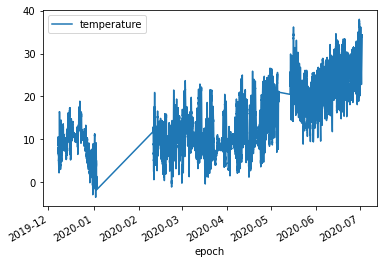

In [10]:
df.plot(x="epoch", y="temperature") # kind="line"

<AxesSubplot:xlabel='epoch'>

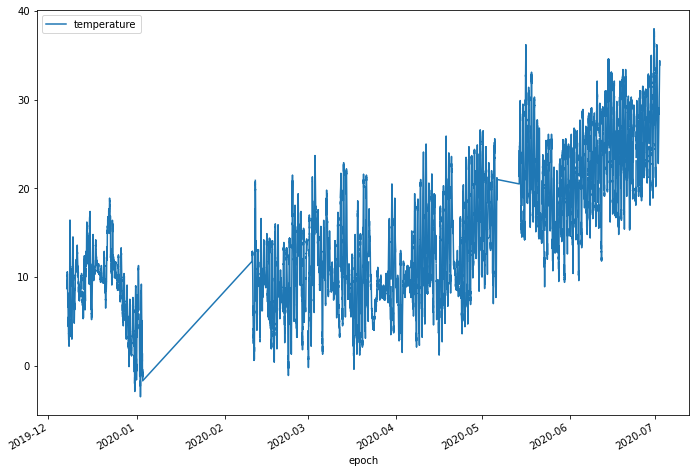

In [11]:
df.plot(x="epoch", y="temperature", figsize=(11.69, 8.27))

In [12]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

<AxesSubplot:xlabel='epoch'>

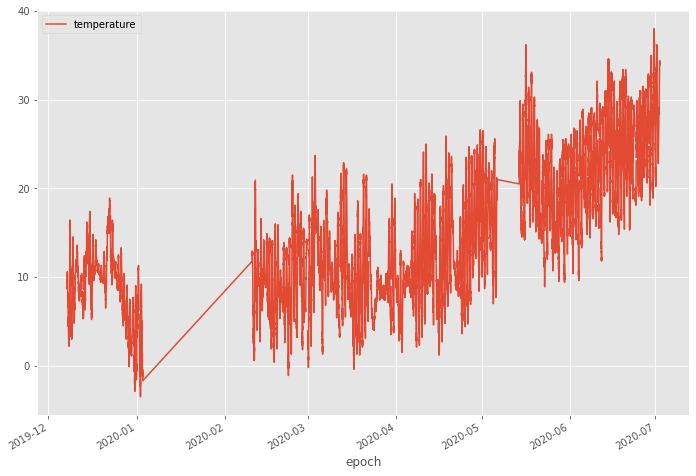

In [13]:
df.plot(x="epoch", y="temperature", figsize=(11.69, 8.27))

### 3.2 Boxplots

<AxesSubplot:title={'center':'temperature'}, xlabel='per'>

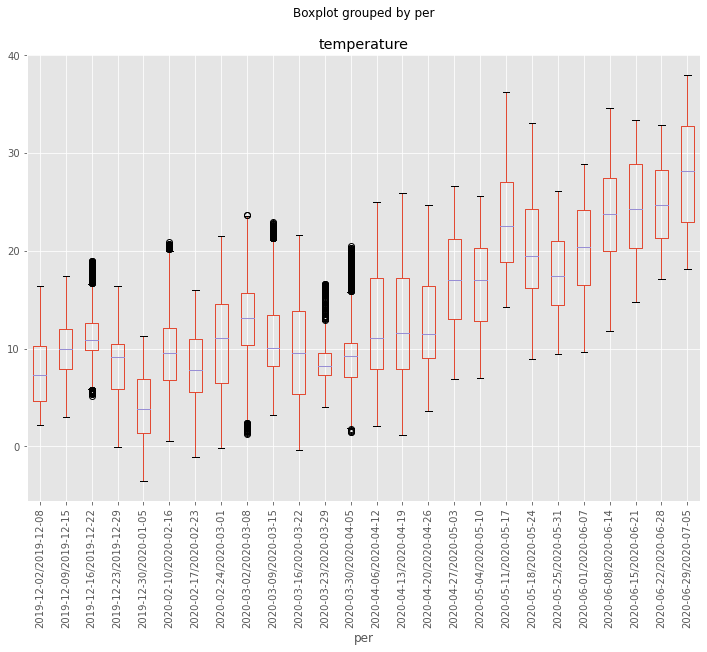

In [14]:
df['per'] = df.set_index("epoch").index.to_period('W')

df.boxplot(column="temperature", by="per", figsize=(11.69, 8.27), rot=90)

<AxesSubplot:title={'center':'temperature'}, xlabel='per'>

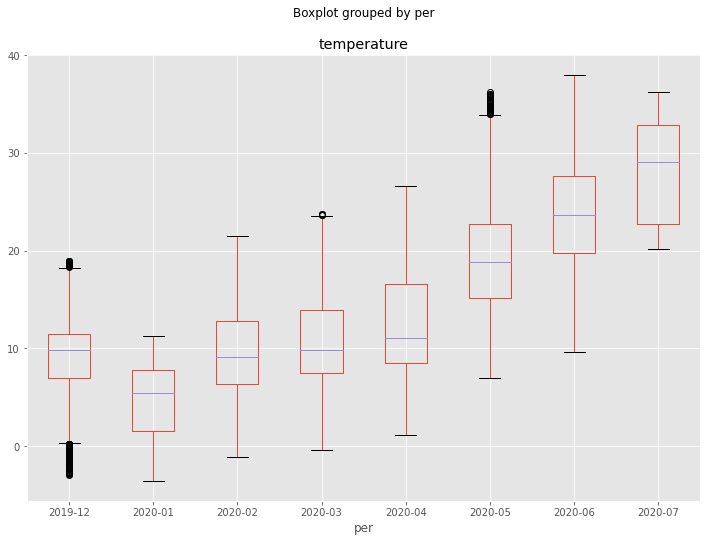

In [15]:
df['per'] = df.set_index("epoch").index.to_period('M')

df.boxplot(column="temperature", by="per", figsize=(11.69, 8.27))

### 3.3 Barplots

It is quite easy to group data per week ...

<AxesSubplot:xlabel='epoch'>

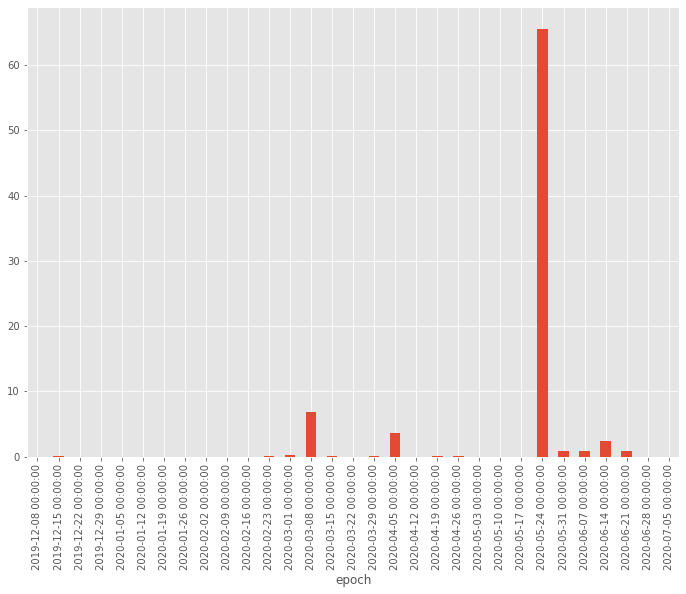

In [20]:
df.set_index("epoch").precipitation.resample("W").sum().plot(kind="bar", figsize=(11.69, 8.27))

### 3.3 Using seaborn

In [28]:
import seaborn

seaborn.set_palette("colorblind")

The DataFrame object is based on the tools used in the R programming language.

There, lots of functions expect the data to be in the "long format". The seaborn library follows this approach, too. To this end we are going to manipulate our data through pandas before feeding it into seaborn. 

In [24]:
sdf = pandas.wide_to_long(
    df=df.drop("cntv3", axis=1),
    stubnames=["vwc", "temp", "ec", "cntv"],
    i="epoch",
    j="sensor"
)
sdf

ai23cnt1                             cenote$id  \
epoch               sensor                                                  
2019-12-07 09:45:24 1          None  9116b3b9-3ed0-4375-bdfa-abb5c651ed2f   
                    2          None  9116b3b9-3ed0-4375-bdfa-abb5c651ed2f   
2019-12-07 09:50:24 1          None  5f08d3b3-9c63-4e62-a6da-be432b07df2c   
                    2          None  5f08d3b3-9c63-4e62-a6da-be432b07df2c   
2019-12-07 09:55:24 1          None  f18dafad-4eea-4127-a71d-575bc40103c0   
...                             ...                                   ...   
2020-07-02 12:30:24 2          None  0b112eaf-3d92-41ae-b494-3318ed70475f   
2020-07-02 12:35:24 1          None  14ba4a95-50e3-49bc-9e37-2755a15a736a   
                    2          None  14ba4a95-50e3-49bc-9e37-2755a15a736a   
2020-07-02 12:40:24 1          None  84a6e6f9-017d-4d7d-8882-6cb2e01201a6   
                    2          None  84a6e6f9-017d-4d7d-8882-6cb2e01201a6   

                            analogv3       f  precipitation unknown16  \
epoch               sensor                                              
2019-12-07 09:45:24 1          100.0  31.2.1            0.0      <NA>   
                    2          100.0  31.2.1            0.0      <NA>   
2019-12-07 09:50:24 1          100.0  31.2.1            0.0      <NA>   
                    2          100.0  31.2.1            0.0      <NA>   
2019-12-07 09:55:24 1          100.0  31.2.1            0.0      <NA>   
...                              ...     ...            ...       ...   
2020-07-02 12:30:24 2            NaN  31.2.1            0.0         0   
2020-07-02 12:35:24 1            NaN  31.2.1            0.0         0   
                    2            NaN  31.2.1            0.0         0   
2020-07-02 12:40:24 1            NaN  31.2.1            0.0         0   
                    2            NaN  31.2.1            0.0         0   

                                       pn ai22rh ai32cnt1 ai31level  ...  gps  \
epoch               sensor                                           ...        
2019-12-07 09:45:24 1       +306948701112   None     None      None  ...    0   
                    2       +306948701112   None     None      None  ...    0   
2019-12-07 09:50:24 1       +306948701112   None     None      None  ...    0   
                    2       +306948701112   None     None      None  ...    0   
2019-12-07 09:55:24 1       +306948701112   None     None      None  ...    0   
...                                   ...    ...      ...       ...  ...  ...   
2020-07-02 12:30:24 2       +306948701112   None     None      None  ...    0   
2020-07-02 12:35:24 1       +306948701112   None     None      None  ...    0   
                    2       +306948701112   None     None      None  ...    0   
2020-07-02 12:40:24 1       +306948701112   None     None      None  ...    0   
                    2       +306948701112   None     None      None  ...    0   

                                             dt  cenote$created_at  ch  \
epoch               sensor                                               
2019-12-07 09:45:24 1       07/12/2019 09:25:24      1575721425134  18   
                    2       07/12/2019 09:25:24      1575721425134  18   
2019-12-07 09:50:24 1       07/12/2019 09:25:24      1575721425236  18   
                    2       07/12/2019 09:25:24      1575721425236  18   
2019-12-07 09:55:24 1       07/12/2019 09:25:24      1575721425354  18   
...                                         ...                ...  ..   
2020-07-02 12:30:24 2       02/07/2020 15:20:24      1602142459301  18   
2020-07-02 12:35:24 1       02/07/2020 15:20:24      1602142459524  18   
                    2       02/07/2020 15:20:24      1602142459524  18   
2020-07-02 12:40:24 1       02/07/2020 15:20:24      1602142459710  18   
                    2       02/07/2020 15:20:24      1602142459710  18   

                                                          

In [26]:
sdf = sdf.reset_index().melt(
    id_vars=["epoch", "sensor"],
    value_vars=["vwc", "temp", "ec", "cntv"]
)
sdf

,epoch,sensor,variable,value
0,2019-12-07 09:45:24,1,vwc,10.39
1,2019-12-07 09:45:24,2,vwc,8.62
2,2019-12-07 09:50:24,1,vwc,10.41
3,2019-12-07 09:50:24,2,vwc,8.62
4,2019-12-07 09:55:24,1,vwc,10.41
...,...,...,...,...
369307,2020-07-02 12:30:24,2,cntv,0.00
369308,2020-07-02 12:35:24,1,cntv,NaN
369309,2020-07-02 12:35:24,2,cntv,0.00
369310,2020-07-02 12:40:24,1,cntv,NaN


In [32]:
sdf['per'] = sdf.set_index("epoch").index.to_period('M')

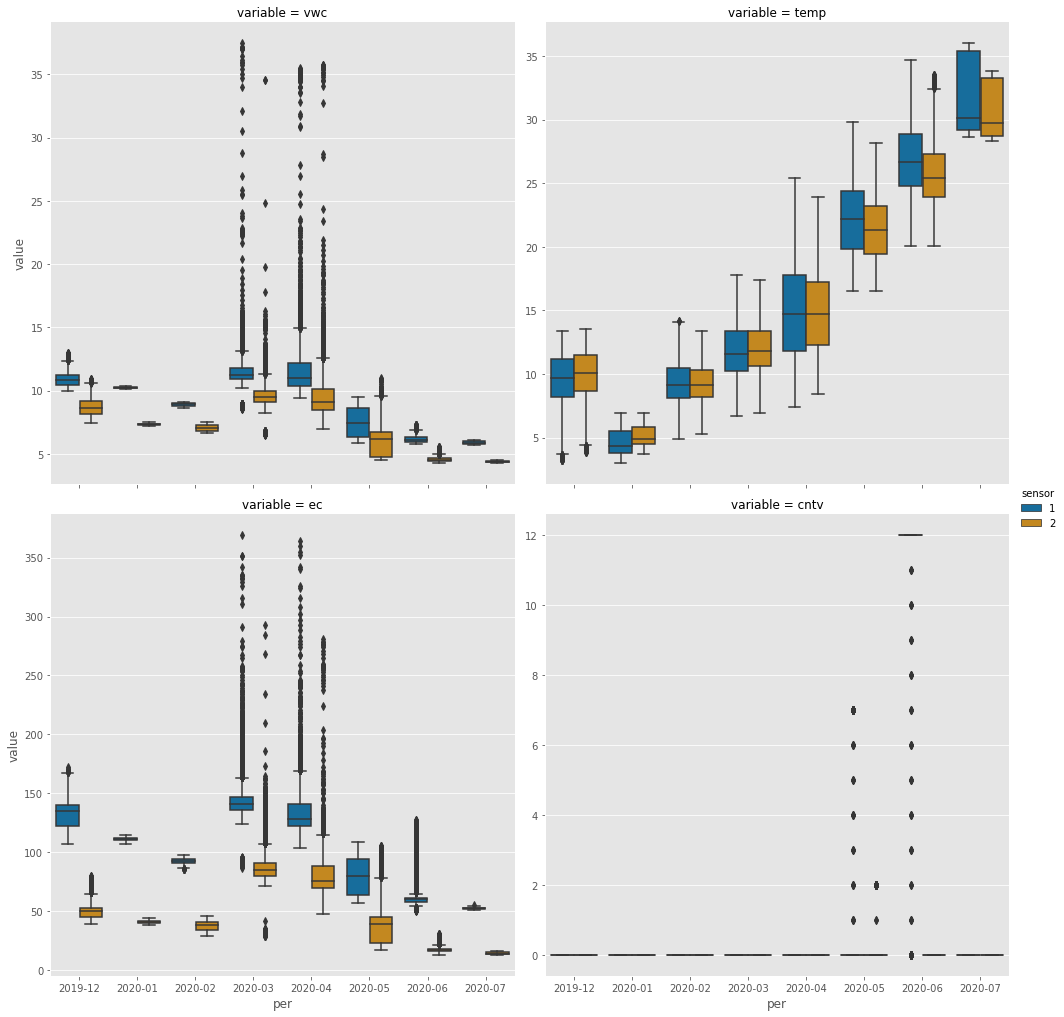

In [37]:
g = seaborn.catplot(
    x="per", y="value",
    hue="sensor", col="variable",
    data=sdf, kind="box",
    height=7, aspect=1, col_wrap=2, sharey=False);